## Part 5

In [1]:
import numpy as np
import matplotlib.pyplot as plt

################################################
#Generate 100 data sets of noisy sinusoidal data
################################################

L = 100  # Number of datasets
N = 25  # Number of data points per dataset
noise_std_dev = 0.3  # Standard deviation of Gaussian noise
np.random.seed(0)


# True underlying function
def t(x):
    return np.sin(2 * np.pi * x)

datasets_x = []
datasets_t = []  # t for target (noisy y)
datasets_t_true = []  # true y for reference

x = np.linspace(0, 1, N)  # Evenly spaced x values, same for all datasets

for i in range(L):
    t_true = t(x)
    t_noisy = t_true + np.random.normal(0, noise_std_dev, N)

    datasets_x.append(x)  # All x will be identical
    datasets_t.append(t_noisy) # All different y
    datasets_t_true.append(t_true)

In [2]:
###################################
#Creating Gaussian basis functions
###################################

M_basis = 24  # Number of Gaussian basis functions
M_biases = 1  #  Number of bias term w0
M_total_params = M_basis + M_biases  # Total parameters M


s_gaussian = 0.1  # Width/scale of Gaussian basis functions - hyperparameter
centers = np.linspace(0, 1, M_basis)  # Centers of Gaussians

def gaussian_basis_function(x, mu, s_param):
    return np.exp(-0.5 * ((x - mu) / s_param) ** 2)

def get_phi(x_input, centers, scale_param):
    N_points = len(x_input)
    M_gaussians = len(centers)
    phi = np.ones((N_points, M_gaussians + 1))
    for j in range(M_gaussians):
        phi[:, j + 1] = gaussian_basis_function(x_input, centers[j], scale_param)
    return phi

In [3]:
######################################
# Functions for Fitting and Prediction
######################################

def fit_regularized_least_squares(phi_matrix, t_vector, lambda_reg):
    M_params = phi_matrix.shape[1]
    identity_matrix = np.identity(M_params)
    A = phi_matrix.T @ phi_matrix + lambda_reg * identity_matrix
    b = phi_matrix.T @ t_vector
    try:
        weights = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        print(
            f"Warning: Singular matrix encountered with lambda={lambda_reg}.\n"
            f"Using pseudo-inverse."
        )
        weights = np.linalg.pinv(A) @ b
    return weights

def predict(phi_matrix, weights):
    return phi_matrix @ weights

In [4]:
#################################################
#Testing Regularized Least Squares on Actual Data
#################################################

dummy_phi = get_phi(datasets_x[0],centers, s_gaussian)
dummy_t = datasets_t[0] 
dummy_lambda = 0.1   
dummy_w = fit_regularized_least_squares(dummy_phi, dummy_t, dummy_lambda)

print(
    f"Example: Weights calculated using data from dataset 0 (lambda={dummy_lambda}), "
    f"first 5 of {len(dummy_w)} elements:\n{dummy_w[:5]}"
)

Example: Weights calculated using data from dataset 0 (lambda=0.1), first 5 of 25 elements:
[ 0.28824849 -0.20897147 -0.08116755  0.18576994  0.38459313]


### Testing Regularized Least Squares on Actual Data (Dataset 0)

We now use the `get_phi()` and `fit_regularized_least_squares()` functions on real, generated data to verify their correctness.

- **`dummy_phi`** is constructed using `datasets_x[0]`, i.e., the input points from the first dataset.
- **`dummy_t`** holds the corresponding target values from `datasets_t[0]`.
- A test regularization value of λ = 0.1 is used to fit the model.

#### Key Dimensions:
- `dummy_phi` has shape (N, M_total_params) = (25, 25)  
  → 25 input points × 25 basis features (including bias term)
- `dummy_t` has shape (N,) = (25,)

In [5]:
lambda_values = [
    1e-9,  # Very low lambda
    1e-2,  # Medium lambda
    1.0,  # High lambda
]

### Intuition Behind the Choice:
λ = 1e-9 behaves almost like unregularized least squares, where the model tries to fit every noisy detail. It helps show what overfitting looks like.

λ = 1e-2 is moderate, offering a good "middle ground" to observe well-generalized model behavior.

λ = 1.0 is strong regularization, which restricts model flexibility and helps show underfitting or oversmoothing.

Prepared dense x-values (shape: (200,)) and corresponding design matrix (shape: (200, 25)) for plotting smooth curves.

--- Processing for: 1e-09 (λ = 1.00e-09) ---
  Obtained model parameters (weights w) for Dataset 0 with 1e-09:
    Shape of w: (25,)
    First 5 weights (w0 is bias): [-137.29665194  390.79004909 -438.80194281 -154.47948826 1001.14133301]
  Stored 100 prediction curves for 1e-09. Shape: (100, 200)


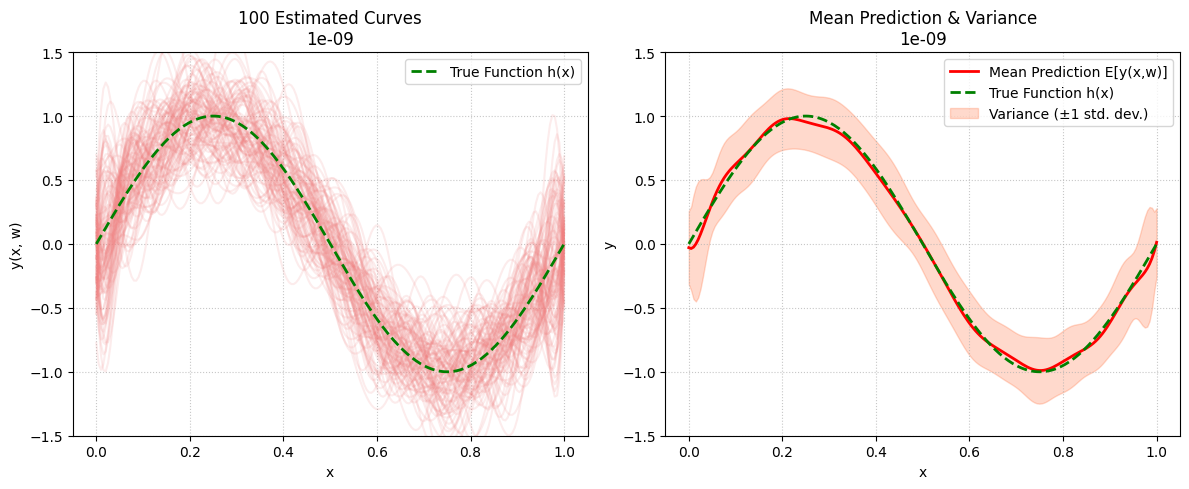


--- Processing for: 0.01 (λ = 1.00e-02) ---
  Obtained model parameters (weights w) for Dataset 0 with 0.01:
    Shape of w: (25,)
    First 5 weights (w0 is bias): [ 1.16688957 -0.60899579 -0.58116866  0.13003692  0.57961854]
  Stored 100 prediction curves for 0.01. Shape: (100, 200)


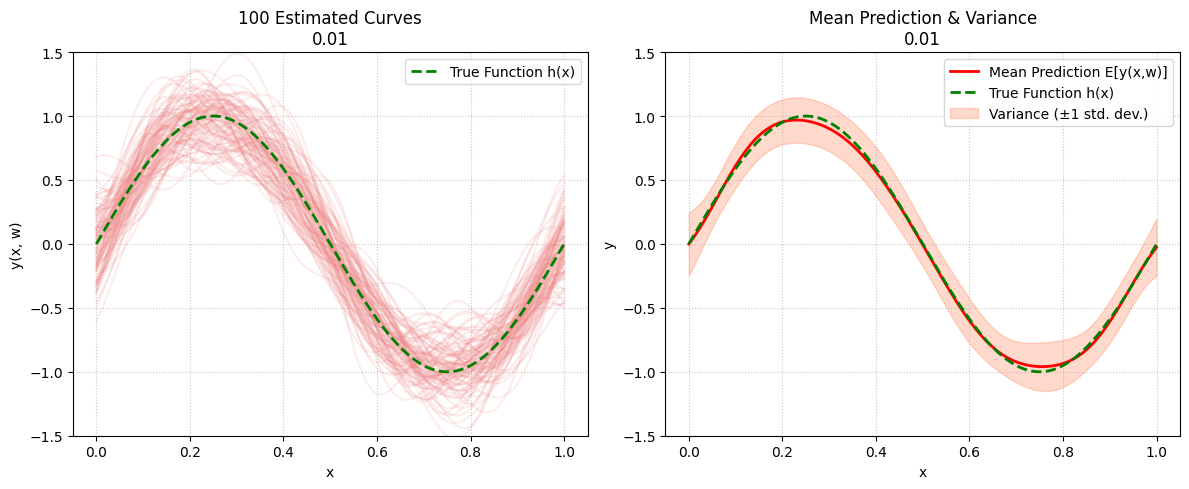


--- Processing for: 1.0 (λ = 1.00e+00) ---
  Obtained model parameters (weights w) for Dataset 0 with 1.0:
    Shape of w: (25,)
    First 5 weights (w0 is bias): [ 0.13766307 -0.01958793  0.06096215  0.16550728  0.24029799]
  Stored 100 prediction curves for 1.0. Shape: (100, 200)


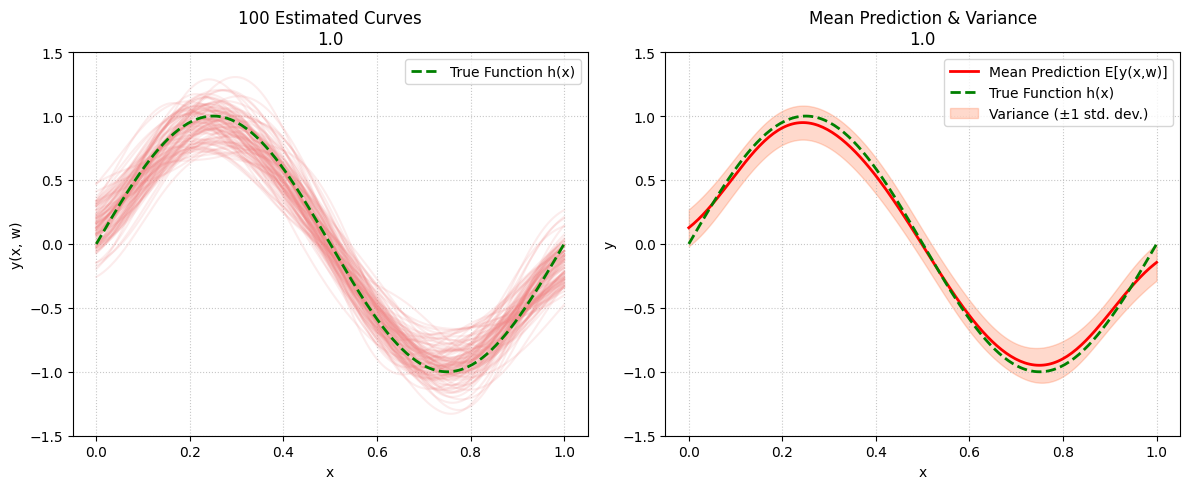


All plots displayed.



In [6]:
#################################################
# Generating Plots for Bias-Variance Illustration
#################################################

x_plot_dense = np.linspace(0, 1, 200)
phi_plot_dense = get_phi(x_plot_dense, centers, s_gaussian)
print(
    f"Prepared dense x-values (shape: {x_plot_dense.shape}) and corresponding design matrix (shape: {phi_plot_dense.shape}) for plotting smooth curves."
)

all_predictions_by_lambda = {}

for i, lambda_reg_val in enumerate(lambda_values):
    current_lambda_name = lambda_values[i]
    print(f"\n--- Processing for: {current_lambda_name} (λ = {lambda_reg_val:.2e}) ---")

    predictions_for_current_lambda_list = []

    # To print weights for one dataset (e.g., the first one) for this lambda
    first_dataset_weights_printed = False

    plt.figure(figsize=(12, 5))  # Figure for the two subplots for current lambda
    plt.subplot(1, 2, 1)  # Left subplot: 100 estimated curves

    for l_idx in range(L):  # Loop through each of the L datasets
        x_train_dataset = datasets_x[l_idx]
        t_train_dataset = datasets_t[l_idx]

        phi_train_dataset = get_phi(
            x_train_dataset,centers, s_gaussian
        )
        w_estimated = fit_regularized_least_squares(
            phi_train_dataset, t_train_dataset, lambda_reg_val
        )

        if (
            l_idx == 0 and not first_dataset_weights_printed
        ):  # Print weights for the first dataset only
            print(
                f"  Obtained model parameters (weights w) for Dataset 0 with {current_lambda_name}:"
            )
            print(f"    Shape of w: {w_estimated.shape}")
            print(f"    First 5 weights (w0 is bias): {w_estimated[:5]}")
            first_dataset_weights_printed = True

        y_pred_dense_single_fit = predict(phi_plot_dense, w_estimated)
        predictions_for_current_lambda_list.append(y_pred_dense_single_fit)
        plt.plot(x_plot_dense, y_pred_dense_single_fit, color="lightcoral", alpha=0.15)

    all_predictions_by_lambda[lambda_reg_val] = np.array(
        predictions_for_current_lambda_list
    )
    print(
        f"  Stored {L} prediction curves for {current_lambda_name}. Shape: {all_predictions_by_lambda[lambda_reg_val].shape}"
    )

    plt.plot(
        x_plot_dense,
        t(x_plot_dense),
        color="green",
        linestyle="--",
        linewidth=2,
        label="True Function h(x)",
    )
    plt.title(f"100 Estimated Curves\n{current_lambda_name}")
    plt.xlabel("x")
    plt.ylabel("y(x, w)")
    plt.ylim(-1.5, 1.5)
    plt.legend(loc="upper right")
    plt.grid(True, linestyle=":", alpha=0.7)

    plt.subplot(1, 2, 2)  # Right subplot: Mean and variance
    mean_prediction_curve = np.mean(all_predictions_by_lambda[lambda_reg_val], axis=0)
    std_dev_prediction_curves = np.std(
        all_predictions_by_lambda[lambda_reg_val], axis=0
    )

    plt.plot(
        x_plot_dense,
        mean_prediction_curve,
        color="red",
        linewidth=2,
        label="Mean Prediction E[y(x,w)]",
    )
    plt.plot(
        x_plot_dense,
        t(x_plot_dense),
        color="green",
        linestyle="--",
        linewidth=2,
        label="True Function h(x)",
    )
    plt.fill_between(
        x_plot_dense,
        mean_prediction_curve - std_dev_prediction_curves,
        mean_prediction_curve + std_dev_prediction_curves,
        color="orangered",
        alpha=0.2,
        label="Variance (±1 std. dev.)",
    )

    plt.title(f"Mean Prediction & Variance\n{current_lambda_name}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.ylim(-1.5, 1.5)
    plt.legend(loc="upper right")
    plt.grid(True, linestyle=":", alpha=0.7)

    plt.tight_layout()
    plt.show()

print("\nAll plots displayed.\n")

### Bias-Variance Trade-off Observations

#### Key Concepts:
- Bias: This shows how far the average prediction of our model is from the actual function we want to learn.
  → High bias means the model is too simple and misses the real pattern (called underfitting).

- Variance: This tells us how much the model’s predictions change when we train it on different datasets.
  → High variance means the model is too sensitive to the training data and may not work well on new data (called overfitting).

- Total Error ≈ Bias² + Variance + Irreducible Error:
  The total error includes:

- Error from wrong assumptions (bias),

- Error from model's sensitivity (variance),

- Plus some random noise we can't remove.

- Regularization (λ): A way to prevent the model from becoming too complex.
  → Higher λ = more control on model, smaller weights, and lower risk of overfitting.

### Observations for Each Regularization Level:

**1. Low λ (e.g., `1.00e-09`):**
*   Printed Weights (Dataset 0): The weights (e.g., `w_estimated[:5]`) might show larger magnitudes compared to higher lambda values, reflecting the model's attempt to fit the data closely.
*   **Plot 1 (100 Estimated Curves):**
    *   Observation: The 100 individual estimated curves (light red) exhibit a wide spread. They wiggle significantly.
    *   Interpretation: High variance. The model is overfitting.
*   **Plot 2 (Mean Estimated Curve & Variance):**
    *   Observation (Mean Curve): The mean estimated curve (solid red) matches with the true sinusoidal function (green dashed line) very closely.
    *   Interpretation (Mean Curve): Low bias.
    *   Observation (Variance Band): The shaded orange area is wide.
    *   Interpretation (Variance Band): Confirms high variance.

**2. Medium λ (e.g., `0.1`):**
*   Printed Weights (Dataset 0): The magnitudes of weights (e.g., `w_estimated[:5]`) are likely smaller/more constrained than for low λ.
*   **Plot 1 (100 Estimated Curves):**
    *   Observation: The spread of the 100 individual curves is noticeably narrower.
    *   Interpretation:REDUCED VARIANCE.
*   Plot 2 (Mean Estimated Curve & Variance):
    *   Observation (Mean Curve): The mean estimated curve (solid red) is reasonably close to the true function.
    *   Interpretation (Mean Curve):* Bias might be slightly higher than for low λ, but relatively low.
    *   Observation (Variance Band): The shaded orange area is narrower.
    *   Interpretation (Variance Band): Shows reduced variance.

**3. High λ (e.g., `1.0`):**
*   Printed Weights (Dataset 0): The weights (e.g., `w_estimated[:5]`) are likely very small, with many close to zero, especially for the basis functions. The bias term `w0` might dominate if it's trying to fit the average of the sine wave.
*   **Plot 1 (100 Estimated Curves):**
    *   Observation: The 100 individual curves are very tightly clustered and much flatter.
    *   Interpretation: Very low variance.
*   **Plot 2 (Mean Estimated Curve & Variance):**
    *   Observation (Mean Curve): The mean estimated curve (solid red) is noticeably different and much simpler than the true function.
    *   Interpretation (Mean Curve): Has high bias. The model is underfitting.
    *   Observation (Variance Band): The shaded orange area is very narrow.
    *   Interpretation (Variance Band): Confirms very low variance.

### Describing the Bias-Variance Trade-off:

The six plots and the behavior of the estimated weights for different λ values clearly demonstrate the bias-variance trade-off:

*   **Low λ:** High model complexity allowed, leading to low bias (average fit is good) but high variance (fits vary wildly with data). Weights can be large.
*   **High λ:** Low model complexity forced by regularization, leading to high bias (average fit is poor, too simple) but low variance (fits are very stable). Weights are small.
*   **Medium λ:** Aims for a sweet spot where the model is complex enough to capture the true signal (moderate bias) but not so complex that it fits the noise (moderate variance). Weights are balanced.

The parameters used (`L=100`, `N=25`, `M_total_params=25`, `noise_std_dev=0.3`, `s_gaussian=0.1`) create a scenario where overfitting is likely without regularization because the number of parameters is equal to the number of data points. Regularization (λ) is crucial for controlling this.

## Part 6

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(0)

# True function
def true_func(x):
    return np.sin(2 * np.pi * x)

# Generate 100 points uniformly in [0, 1]
x = np.linspace(0, 1, 100)
x = x.reshape(-1,1)
t = (true_func(x) + np.random.normal(0, 0.1, size=x.shape)).flatten() # noise std = 0.1

# Choose 20 basis functions with centers evenly spaced in [0,1]
M = 20
centers = np.linspace(0, 1, M)
centers = centers.reshape(1,-1)
sigma = 0.05  # width of each Gaussian
Phi = gaussian_basis_function(x, centers, sigma)


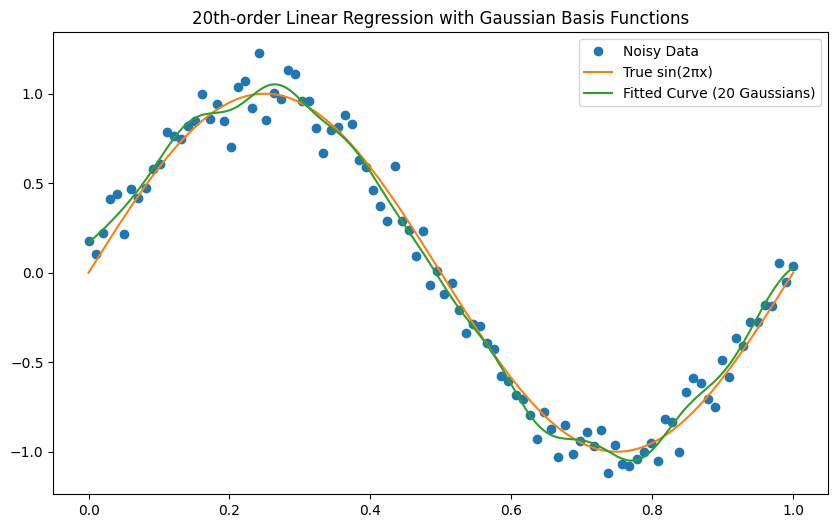

In [8]:
# Predict
lamda = 0.01
x_test = np.linspace(0, 1, 1000)
x_test = x_test.reshape(-1,1)
w = fit_regularized_least_squares(Phi,t,lamda)
Phi_test = gaussian_basis_function(x_test, centers, sigma)
y_pred = Phi_test @ w

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, t, 'o', label='Noisy Data')
plt.plot(x_test, true_func(x_test), label='True sin(2πx)')
plt.plot(x_test, y_pred, label='Fitted Curve (20 Gaussians)')
plt.legend()
plt.title('20th-order Linear Regression with Gaussian Basis Functions')
plt.show()


In [9]:
def bayesian_update(prior_mean, prior_cov, phi_x, t_val, sigma2):
    """
    Update the posterior mean and covariance with a new (phi_x, t_val) pair.
    """
    phi_x = phi_x.reshape(-1, 1)  # Ensure column vector
    S_inv = np.linalg.inv(prior_cov)
    
    # Update posterior covariance
    S_new_inv = S_inv + (1 / sigma2) * (phi_x @ phi_x.T)
    S_new = np.linalg.inv(S_new_inv)
    
    # Update posterior mean
    m_new = S_new @ (S_inv @ prior_mean + (1 / sigma2) * phi_x.flatten() * t_val)
    
    return m_new, S_new


In [10]:
D = Phi.shape[1]           # Number of basis functions
sigma2 = 0.01              # Known noise variance (σ²)
m_prior = np.zeros(D)      # Prior mean: zero vector
S_prior = np.eye(D)        # Prior covariance: identity matrix
m_N, S_N = m_prior.copy(), S_prior.copy()  # Start with prior

for i in range(Phi.shape[0]):  # Loop through training examples
    phi_xi = Phi[i]      # Row i from design matrix
    t_i = t[i]           # Corresponding target value
    m_N, S_N = bayesian_update(m_N, S_N, phi_xi, t_i, sigma2)


In [11]:
n_samples = 100
sampled_curves = []

for _ in range(n_samples):
    w_sample = np.random.multivariate_normal(mean=m_N, cov=S_N)
    y_sample = predict(Phi_test, w_sample)
    sampled_curves.append(y_sample)

sampled_curves = np.array(sampled_curves)
average_curve = np.mean(sampled_curves, axis=0)


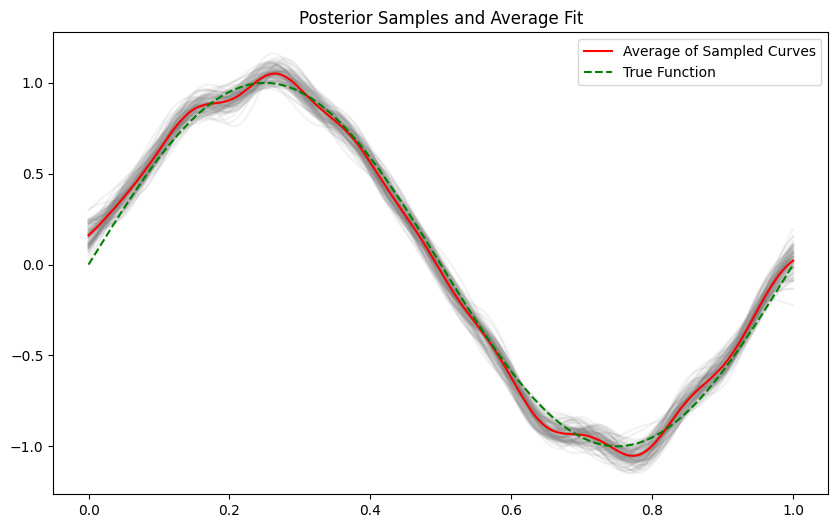

In [12]:
plt.figure(figsize=(10, 6))
for i in range(n_samples):
    plt.plot(x_test, sampled_curves[i], color='gray', alpha=0.1)

plt.plot(x_test, average_curve, label='Average of Sampled Curves', color='red')
plt.plot(x_test, true_func(x_test), label='True Function', linestyle='--', color='green')
plt.legend()
plt.title("Posterior Samples and Average Fit")
plt.show()


In [13]:
mu_preds = []
std_preds = []
noise_variance = 0.01

for phi_x0 in Phi_test:  # loop over test design matrix rows
    phi_x0 = phi_x0.reshape(-1, 1)
    mu = (phi_x0.T @ m_N).item()
    sigma2 = (phi_x0.T @ S_N @ phi_x0).item() + noise_variance
    mu_preds.append(mu)
    std_preds.append(np.sqrt(sigma2))


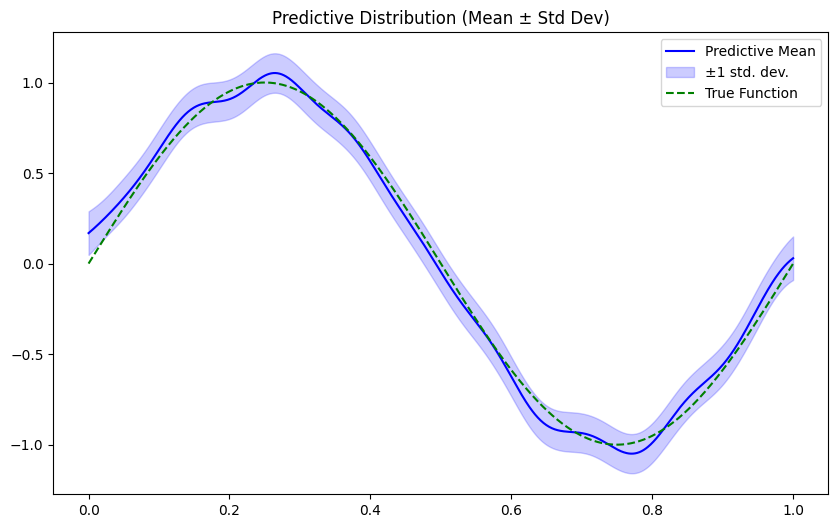

In [14]:
mu_preds = np.array(mu_preds)
std_preds = np.array(std_preds)

plt.figure(figsize=(10,6))
plt.plot(x_test, mu_preds, label="Predictive Mean", color='blue')
plt.fill_between(x_test.flatten(), mu_preds - std_preds, mu_preds + std_preds,
                 color='blue', alpha=0.2, label="±1 std. dev.")
plt.plot(x_test, true_func(x_test), label="True Function", linestyle='--', color='green')
plt.legend()
plt.title("Predictive Distribution (Mean ± Std Dev)")
plt.show()



--- Predictive Distribution Using First 2 Data Points ---


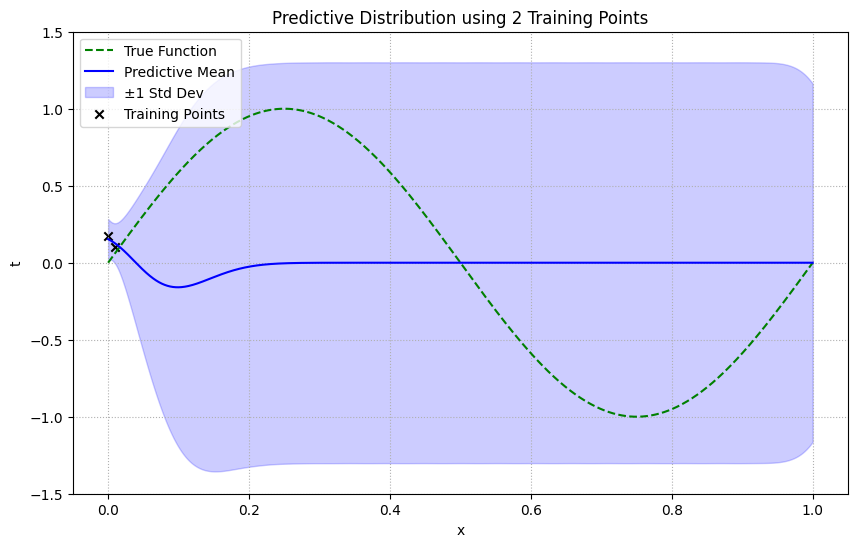


--- Predictive Distribution Using First 5 Data Points ---


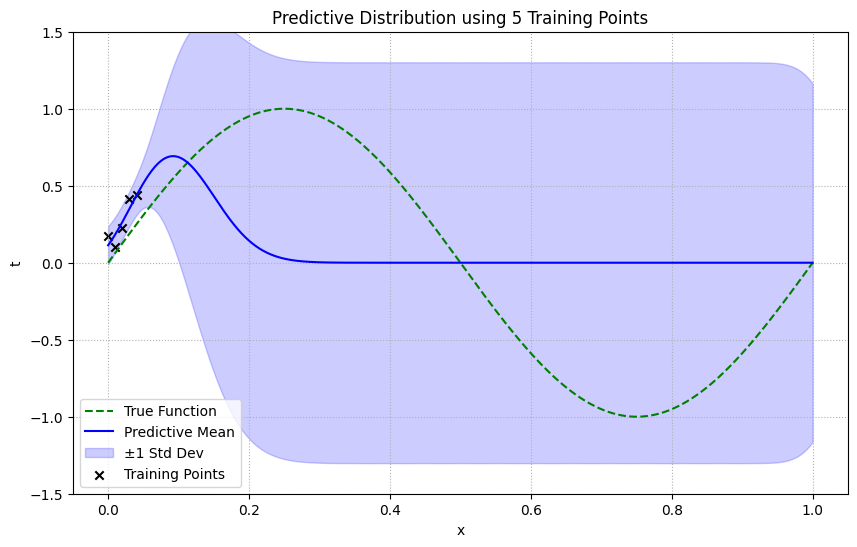


--- Predictive Distribution Using First 10 Data Points ---


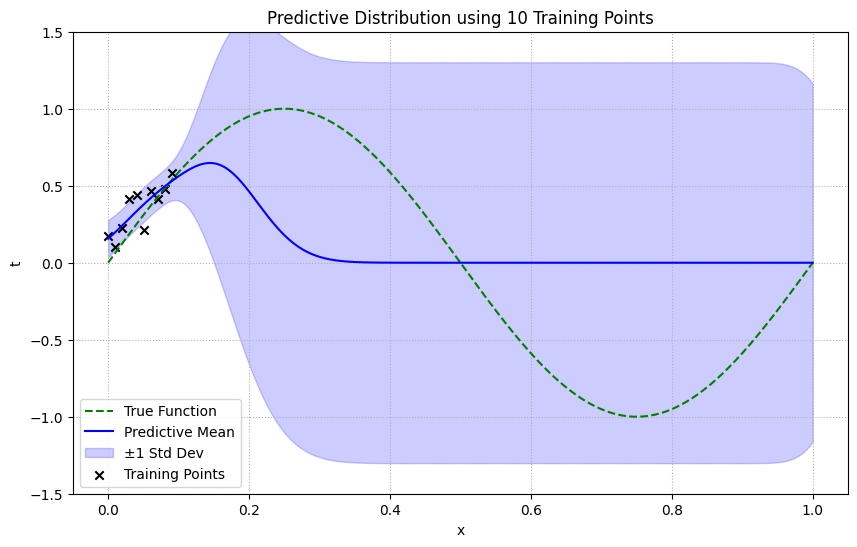


--- Predictive Distribution Using First 25 Data Points ---


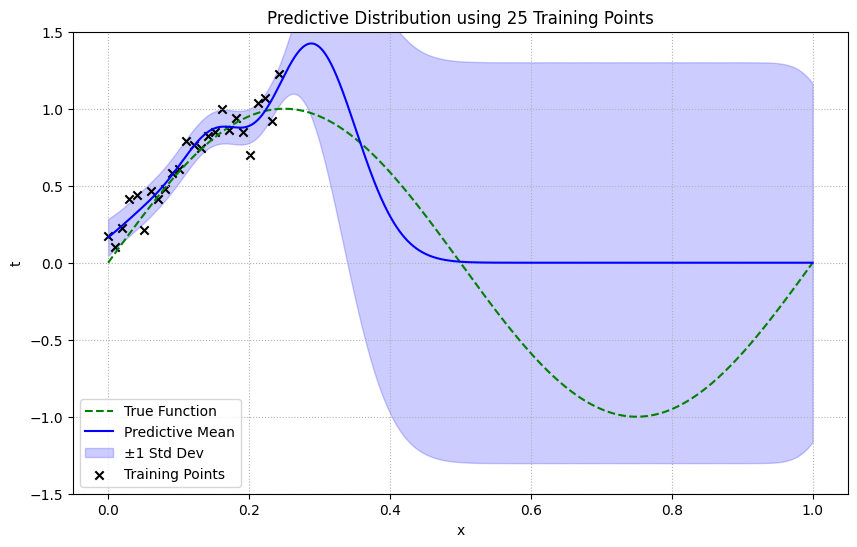

In [15]:
# Training sizes to experiment with
training_sizes = [2, 5, 10, 25]
sigma2 = 0.01  # Noise variance
noise_std = np.sqrt(sigma2)

for n_train in training_sizes:
    print(f"\n--- Predictive Distribution Using First {n_train} Data Points ---")
    
    # Slice first n_train points from training set
    Phi_subset = Phi[:n_train]
    t_subset = t[:n_train]

    # Initialize prior
    D = Phi.shape[1]
    m_N = np.zeros(D)
    S_N = np.eye(D)

    # Sequential Bayesian update
    for i in range(n_train):
        phi_xi = Phi_subset[i]
        t_i = t_subset[i]
        m_N, S_N = bayesian_update(m_N, S_N, phi_xi, t_i, sigma2)

    # Predictive mean and std for test set
    mu_preds = []
    std_preds = []

    for phi_x0 in Phi_test:
        phi_x0 = phi_x0.reshape(-1, 1)
        mu = (phi_x0.T @ m_N).item()
        pred_var = (phi_x0.T @ S_N @ phi_x0).item() + sigma2
        mu_preds.append(mu)
        std_preds.append(np.sqrt(pred_var))

    mu_preds = np.array(mu_preds)
    std_preds = np.array(std_preds)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(x_test, true_func(x_test), 'g--', label='True Function')
    plt.plot(x_test, mu_preds, 'b', label='Predictive Mean')
    plt.fill_between(x_test.flatten(),
                     mu_preds - std_preds,
                     mu_preds + std_preds,
                     color='blue', alpha=0.2, label='±1 Std Dev')

    plt.scatter(x[:n_train], t[:n_train], color='black', marker='x', label='Training Points')
    plt.title(f"Predictive Distribution using {n_train} Training Points")
    plt.xlabel("x")
    plt.ylabel("t")
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.ylim(-1.5, 1.5)
    plt.show()
